# EfficientNet Model

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://tfhub.dev/google/collections/efficientnet/1


In [1]:
!ln -s /usr/local/cuda-11.1/targets/x86_64-linux/lib/libcusolver.so.11.0.1.105 /usr/local/cuda-11.1/targets/x86_64-linux/lib/libcusolver.so.10

In [2]:
from PIL import Image
from io import BytesIO
import os
import requests
import tensorflow as tf
import numpy as np
import boto3
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from cmlbootstrap import CMLBootstrap
from subprocess import check_output
from smart_open import open

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import pathlib
data_dir = pathlib.Path("/home/cdsw/data/train")

In [5]:
batch_size = 32
img_height = 300
img_width = 300
IMG_SIZE = (300, 300)

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4490 files belonging to 3 classes.
Using 3592 files for training.


In [7]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4490 files belonging to 3 classes.
Using 898 files for validation.


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.05),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomZoom(0.05),
    ],
    name="img_augmentation",
)  

In [11]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim([0,1])
    plt.show()

In [12]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB3

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = img_augmentation(inputs)

model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization(name="last_batch_norm")(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(3, name="pred", activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [13]:
len(model.trainable_variables)

342

In [14]:
model.trainable = True

for i, layer in enumerate(model.layers):
  if i > len(model.layers) - 21:
      if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True
      else:
          if layer.name == "last_batch_norm":
              layer.trainable = True
          else:
              layer.trainable = False
  else:
      layer.trainable = False

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [16]:
len(model.trainable_variables)

11

In [17]:
epochs = 30
hist = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, verbose=2)

Epoch 1/30
113/113 - 196s - loss: 0.8204 - accuracy: 0.6840 - val_loss: 0.6907 - val_accuracy: 0.7304
Epoch 2/30
113/113 - 66s - loss: 0.6295 - accuracy: 0.7514 - val_loss: 0.6244 - val_accuracy: 0.7236
Epoch 3/30
113/113 - 66s - loss: 0.5442 - accuracy: 0.7815 - val_loss: 0.5305 - val_accuracy: 0.7602
Epoch 4/30
113/113 - 66s - loss: 0.5139 - accuracy: 0.7895 - val_loss: 0.5042 - val_accuracy: 0.7791
Epoch 5/30
113/113 - 66s - loss: 0.4862 - accuracy: 0.7987 - val_loss: 0.5444 - val_accuracy: 0.7764
Epoch 6/30
113/113 - 66s - loss: 0.4698 - accuracy: 0.8093 - val_loss: 0.5466 - val_accuracy: 0.7805
Epoch 7/30
113/113 - 66s - loss: 0.4608 - accuracy: 0.8054 - val_loss: 0.4907 - val_accuracy: 0.7981
Epoch 8/30
113/113 - 66s - loss: 0.4528 - accuracy: 0.8112 - val_loss: 0.4955 - val_accuracy: 0.7940
Epoch 9/30
113/113 - 66s - loss: 0.4365 - accuracy: 0.8185 - val_loss: 0.5092 - val_accuracy: 0.7967
Epoch 10/30
113/113 - 66s - loss: 0.4228 - accuracy: 0.8246 - val_loss: 0.5045 - val_accur

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 4s 402ms/step - loss: 0.4502 - accuracy: 0.8188
Test accuracy : 0.8187500238418579


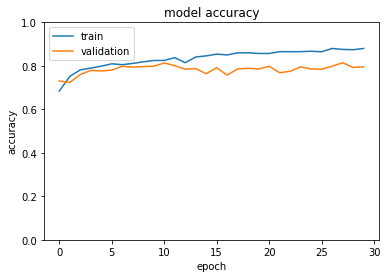

In [19]:
plot_hist(hist)

In [ ]:
#model.save("models/model_2_efficient.h5")